In [1]:
import datetime as dt
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
os.chdir(r"..")
from util import get_data, plot_data
os.chdir(r"./indicator_evaluation")
import typing

In [2]:
start_val = 100000
symbol = "JPM"
symbols = ["JPM"]
#January 1, 2008, to December 31, 2009
sd = dt.datetime(2008,1,1)
ed = dt.datetime(2009,12,31)
dates = pd.date_range(start=sd,end=ed)
prices = get_data(symbols=symbols, dates=dates)
prices = prices.dropna(subset=["SPY"])
prices = prices[symbols]
prices = prices.fillna(method="ffill").fillna(method="bfill")
# prices["Cash"] = 1.0

In [3]:
# 1. Moving Averages (Choose which one you want, do not keep both!)
# https://www.investopedia.com/terms/m/movingaverage.asp
# https://www.investopedia.com/ask/answers/071414/whats-difference-between-moving-average-and-weighted-moving-average.asp
# https://www.investopedia.com/articles/trading/10/simple-exponential-moving-averages-compare.asp
def SMA(prices: pd.DataFrame, window: int = 50)->pd.DataFrame:
    # https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/sma
    # https://www.investopedia.com/terms/s/sma.asp
    """A function that returns the Simple Moving Average based on user input

    Args:
        prices (pd.DataFrame): Prices DataFrame
        window (int): How far back to look for the SMA. Recommended to fill in yourself
                      Usually 50 for short and 200 for long. These numbers are used for the golden cross method

    Returns:
        pd.DataFrame: A dataframe with the simple moving avearge calculated
    """
    offset_days = dt.timedelta(days=window*2)
    dates = pd.date_range(prices.index.min()-offset_days,prices.index.max())
    prices_window = get_data(prices.columns, dates)
    prices_window = prices_window.dropna(subset=["SPY"])
    prices_window = prices_window[prices.columns]
    prices_window = prices_window.fillna(method="ffill").fillna(method="bfill")
    
    return prices_window.rolling(window).mean()
def EMA(prices: pd.DataFrame, window: int = 10)-> pd.DataFrame:
    # Used for MACD
    # https://www.investopedia.com/articles/technical/060401.asp
    # https://www.investopedia.com/terms/e/ema.asp
    """A function that returns the Exponential Moving Average based on user input

    Args:
        prices (pd.DataFrame): Prices Dataframe
        window (int): How far back to look for the EMA. Defaults to 10, but has been known to be 50, 200

    Returns:
        pd.DataFrame: A dataframe with the exponential moving avearge calculated
    """
    offset_days = dt.timedelta(days=window*2)
    dates = pd.date_range(prices.index.min()-offset_days,prices.index.max())
    prices_window = get_data(prices.columns, dates)
    prices_window = prices_window.dropna(subset=["SPY"])
    prices_window = prices_window[prices.columns]
    prices_window = prices_window.fillna(method="ffill").fillna(method="bfill")
    
    return prices_window.ewm(span=window, adjust=False, min_periods=window).mean()
def WMA(prices: pd.DataFrame, window: int)-> pd.DataFrame:
    # https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
    # https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/wma
    # This is not Wilder Moving Average
    """A function that returns the Weighted Moving Average based on user input

    Args:
        prices (pd.DataFrame): Prices Dataframe
        window (int): How far back to look for the WMA

    Returns:
        pd.DataFrame: A dataframe with the weighted moving avearge calculated
    """
    offset_days = dt.timedelta(days=window*2)
    dates = pd.date_range(prices.index.min()-offset_days,prices.index.max())
    prices_window = get_data(prices.columns, dates)
    prices_window = prices_window.dropna(subset=["SPY"])
    prices_window = prices_window[prices.columns]
    prices_window = prices_window.fillna(method="ffill").fillna(method="bfill")

    weights = np.arange(window)/np.arange(window).sum()
    return prices_window.rolling(window).apply(lambda price: np.sum(price*weights), raw=True)

# 1.1 Crosses
def Generic_Cross(prices: pd.DataFrame, short:int = 50, long:int = 200, ma_func:typing.Callable = SMA)->pd.DataFrame:
    # https://www.investopedia.com/terms/g/goldencross.asp
    """Produces a chart for the golden cross using SMA}

    Args:
        prices (pd.DataFrame): Prices DataFrame
        short (int, optional): The look back period for short periods. Defaults to 50.
        long (int, optional): The look back period for long periods. Defaults to 200.
        ma_func(Callable, optional): The moving average function of choice: Defaults to SMA
    
    Returns:
        pd.DataFrame: A dataframe with the MA_Short/MA_Long - 1. Subtracting 1 to make crossing point = 0 rather than 1
    """
    ma_short = ma_func(prices, short)
    ma_long  = ma_func(prices, long)
    cross = (ma_short/ma_long)-1
    return cross
def Golden_Cross(prices:pd.DataFrame, short:int=50, long:int=200)->pd.DataFrame:
    # https://www.tradingsim.com/blog/golden-cross
    # "All big rallies start with a golden cross, but not all golden crosses lead to a big rally"
    # Ari Wald, Head of Technical Analysis at Oppenheimer & Co.
    # Brian Shannon is the founder of AlphaTrends.net. He also agrees that golden crosses are not a definite timing signal to buy.
    # According to Shannon, “They tend not to be timing signals, but more for confirmation of a move that has been in place.”
    """Uses Crossing of MA data to calculate Golden Cross. Good for detecting Buy Opportunities

    Args:
        prices (pd.DataFrame): Prices DataFrame
        short (int, optional): The look back period for short periods. Defaults to 50.
        long (int, optional): The look back period for long periods. Defaults to 200.
    
    Returns:
        pd.DataFrame: A dataframe with the Golden Cross Points
    """
    cross = Generic_Cross(prices=prices, short=short, long=long).dropna(how="all")
    g_cross = (cross>=0) & (cross.shift(1)<0)
    g_cross = g_cross.astype(int) # 0 = False, 1 = True
    return g_cross    
def Death_Cross(prices:pd.DataFrame, short:int=50, long:int=200)->pd.DataFrame:
    """Uses Crossing of MA data to calculate Death Cross. Possible Sell Point?

    Args:
        prices (pd.DataFrame): Prices DataFrame
        short (int, optional): The look back period for short periods. Defaults to 50.
        long (int, optional): The look back period for long periods. Defaults to 200.
    
    Returns:
        pd.DataFrame: A dataframe with the Death Cross Points
    """
    cross = Generic_Cross(prices=prices, short=short, long=long).dropna(how="all")
    d_cross = (cross<=0) & (cross.shift(1)>0)
    d_cross = d_cross.astype(int) # 0 = False, 1 = True
    return d_cross    

# 2. BB% (You need BB to calculate BB%)
def Bollinger_Bands(prices: pd.DataFrame, window: int=20)-> tuple:
    # https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/bollinger-bands
    """A function to return the upper and lower Bollinger Bands

    Args:
        prices (pd.DataFrame): Prices Dataframe
        window (int): How far back to look for the BB

    Returns:
        tuple: A tuple where element 0 is the lower bands and element 1 is the upper bands
    """
    offset_days = dt.timedelta(days=window*2)
    dates = pd.date_range(prices.index.min()-offset_days,prices.index.max())
    prices_window = get_data(prices.columns, dates)
    prices_window = prices_window.dropna(subset=["SPY"])
    prices_window = prices_window[prices.columns]
    prices_window = prices_window.fillna(method="ffill").fillna(method="bfill")
    
    prices_std = prices_window.rolling(window).std()
    prices_sma = SMA(prices_window, window)
    lower_band = prices_sma-(2*prices_std)
    upper_band = prices_sma+(2*prices_std)
    return lower_band, upper_band
def BB_Pct(prices: pd.DataFrame, window: int=20)->pd.DataFrame:
    """Calculating the Bollinger Bands Value as a percent

    Args:
        price (pd.DataFrame): Prices Dataframe
        window (int): How far back to look for the BB.
                      Used when calling Bollinger_Bands(prices: pd.DataFrame, window: int)

    Returns:
        pd.DataFrame: A dataframe with the prices relative position to the BB as a % where 0% is on the lower band and 100% is the upper band
    """
    offset_days = dt.timedelta(days=window*2)
    dates = pd.date_range(prices.index.min()-offset_days,prices.index.max())
    prices_window = get_data(prices.columns, dates)
    prices_window = prices_window.dropna(subset=["SPY"])
    prices_window = prices_window[prices.columns]
    prices_window = prices_window.fillna(method="ffill").fillna(method="bfill")
    
    bands = Bollinger_Bands(prices, window)
    return (prices_window - bands[0])/(bands[1] - bands[0])

# 3. Momentum vs ROC (Choose which one you want, do not keep both!)
def momentum(prices: pd.DataFrame, window: int= 10)-> pd.DataFrame:
    # https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/momentum
    # https://www.investopedia.com/terms/m/momentum_investing.asp
    # https://www.investopedia.com/terms/m/marketmomentum.asp
    """A function that returns the Momentum of a stock 

    Args:
        prices (pd.DataFrame): Prices Dataframe
        window (int): How far back to look for the Momentum. Defaults to 10

    Returns:
        pd.DataFrame: A dataframe with the momentum calculated
    """
    offset_days = dt.timedelta(days=window*2)
    dates = pd.date_range(prices.index.min()-offset_days,prices.index.max())
    prices_window = get_data(prices.columns, dates)
    prices_window = prices_window.dropna(subset=["SPY"])
    prices_window = prices_window[prices.columns]
    prices_window = prices_window.fillna(method="ffill").fillna(method="bfill")
    
    return prices_window.diff(1)
def rate_of_change(prices: pd.DataFrame, window: int = 10)-> pd.DataFrame:
    # https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/ROC
    # https://www.investopedia.com/terms/p/pricerateofchange.asp
    # https://www.investopedia.com/terms/m/momentum_investing.asp
    """A function that returns the Rate of Change of a stock

    Args:
        prices (pd.DataFrame): Prices Dataframe
        window (int): How far back to look for the Rate of Change. Defaults to 10. Can be 200 if long term is your goal

    Returns:
        pd.DataFrame: A dataframe with the Rate of Change calculated
    """
    offset_days = dt.timedelta(days=window*2)
    dates = pd.date_range(prices.index.min()-offset_days,prices.index.max())
    prices_window = get_data(prices.columns, dates)
    prices_window = prices_window.dropna(subset=["SPY"])
    prices_window = prices_window[prices.columns]
    prices_window = prices_window.fillna(method="ffill").fillna(method="bfill")
    
    return (prices_window-prices_window.shift(window))/prices_window.shift(window)

# 4. Moving Average Convergence Divergence (MACD)
def MACD(prices: pd.DataFrame, fast: int=12, slow: int=26, signal_window:int = 9)-> tuple:
    # https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
    # https://www.alpharithms.com/calculate-macd-python-272222/
    # https://www.investopedia.com/terms/m/movingaverage.asp
    # https://www.investopedia.com/terms/m/macd.asp
    # https://www.investopedia.com/terms/m/momentum_investing.asp
    """A function that calculates Moving Average Convergence Divergence

    Args:
        prices (pd.DataFrame): Prices Dataframe
        fast (int, optional): How far back to look for MACD fast. Defaults to 12.
        slow (int, optional): How far back to look for MACD slow. Defaults to 26.
        signal (int, optional): How far back to look for MACD signal. Defaults to 9.

    Returns:
        tuple: A tuple with 3 dataframes: The MACD, Signal Line, and Histogram
    """
    ema_fast = EMA(prices=prices, window=fast)
    ema_slow = EMA(prices=prices, window=slow)
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_window, adjust = False, min_periods = signal_window).mean()
    histogram = macd - signal
    return macd, signal, histogram

# 5. Stochastic Oscillators
def Stochastic_Oscillators(prices: pd.DataFrame, k: int=14, d: int=3)-> tuple:
    # https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
    # https://www.alpharithms.com/stochastic-oscillator-in-python-483214/
    # https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/fast-stochastic
    """A function that calculates Stochastic Oscilators

    Args:
        prices (pd.DataFrame): Prices Dataframe
        k (int, optional): How far back to look for Stochastic Oscillators k. Defaults to 14.
        d (int, optional): How far back to look for Stochastic Oscillators d. Defaults to 3.

    Returns:
        tuple: A tuple with 2 dataframes: Stochastic Oscillators fast and Stochastic Oscillators slow
    """
    offset_days = dt.timedelta(days=k*2)
    dates = pd.date_range(prices.index.min()-offset_days,prices.index.max())
    lows = get_data(prices.columns, dates, colname="Low")
    lows = lows.dropna(subset=["SPY"])
    lows = lows[prices.columns]
    lows = lows.fillna(method="ffill").fillna(method="bfill")
    
    highs = get_data(prices.columns, dates, colname="High")
    highs = highs.dropna(subset=["SPY"])
    highs = highs[prices.columns]
    highs = highs.fillna(method="ffill").fillna(method="bfill")
    
    close = get_data(prices.columns, prices.index, colname="Close")
    close = close.dropna(subset=["SPY"])
    close = close[prices.columns]
    close = close.fillna(method="ffill").fillna(method="bfill")
    
    low_k_mins = lows.rolling(k).min()
    low_k_mins = low_k_mins.loc[prices.index]
    high_k_maxs = highs.rolling(k).max()
    high_k_maxs = high_k_maxs.loc[prices.index]
    
    stochastic_k = (close - low_k_mins)/(high_k_maxs - low_k_mins)
    stochastic_d = stochastic_k.rolling(d).mean()
    
    # Maybe returning the ratio between fast and moving average?
    return stochastic_k, stochastic_d



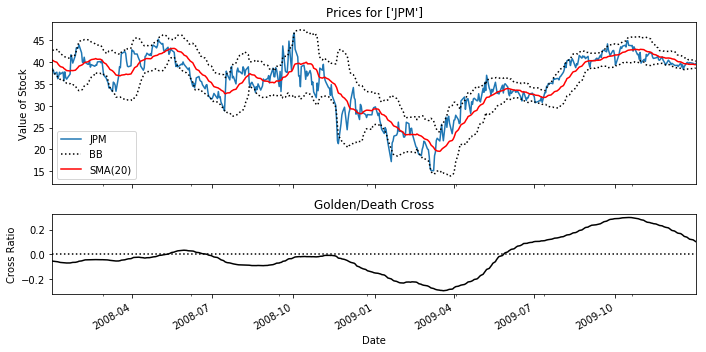

In [24]:
# 1. Moving Averages (Choose which one you want, do not keep both!)
# 1.1 Crosses
xlim_dates = [dt.date(2008, 1, 1), dt.date(2010, 1, 1)]
figsize_tup = (10,5)
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=figsize_tup, sharex=True,
                      gridspec_kw={'height_ratios': [1, 0.5]})

ax[0].plot(prices, label = "JPM")
sma = SMA(prices, window=20).loc[xlim_dates[0]:]
bands = Bollinger_Bands(prices)
ax[0].plot(bands[0].loc[xlim_dates[0]:], color = "black", linestyle=":", label = "BB")
ax[0].plot(bands[1].loc[xlim_dates[0]:], color = "black", linestyle=":", label="_nolegend_")
ax[0].plot(sma, color = "red", label="SMA(20)")
ax[0].legend()

cross = Generic_Cross(prices).loc[xlim_dates[0]:]
cross.plot(ax=ax[1],color="black",legend=False)
# gcross = Golden_Cross(prices)
# dcross = Death_Cross(prices)
# cross[gcross==1].plot(ax=ax[1],marker="o",markersize=12,color="Gold",linestyle='None',legend=False)
# cross[dcross==1].plot(ax=ax[1],marker="o",markersize=12,color="Red",linestyle='None',legend=False)
ax[1].hlines(y=0,xmin=prices.index.min(),xmax=prices.index.max(),linestyle=":")

ax[0].set_title(f"Prices for {symbols}")
ax[0].set_xlabel("Date")
ax[1].set_xlabel("Date")
ax[0].set_ylabel("Value of Stock")
ax[1].set_ylabel("Cross Ratio")
ax[1].set_title("Golden/Death Cross")
# ax[0].set_xlim(xlim_dates)
# ax[1].set_xlim(xlim_dates)
fig.tight_layout()
plt.savefig("p6_indicator_cross.png")

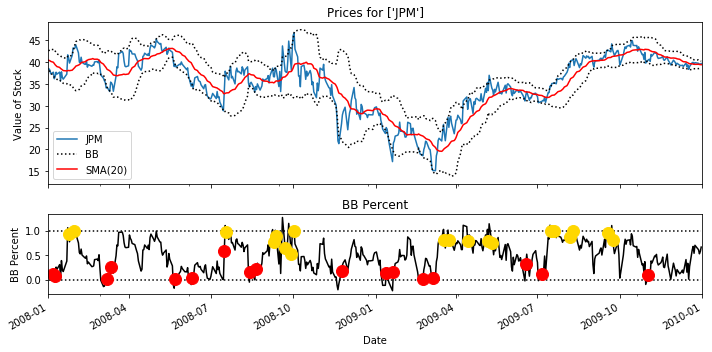

In [18]:
# 2. BB% (You need BB to calculate BB%)
n_rows = 2
fig, ax = plt.subplots(nrows=n_rows,ncols=1,figsize=figsize_tup, sharex=True,
                      gridspec_kw={'height_ratios': [1]+([0.5]*(n_rows-1))})

ax[0].plot(prices, label = "JPM")
sma = SMA(prices, window=20)
bands = Bollinger_Bands(prices)
ax[0].plot(bands[0], color = "black", linestyle=":", label = "BB")
ax[0].plot(bands[1], color = "black", linestyle=":", label="_nolegend_")
ax[0].plot(sma, color = "red", label="SMA(20)")
ax[0].legend()

bbpct = BB_Pct(prices).dropna()
bbpct.plot(ax=ax[1],color="black",legend=False)
bbpct[((bbpct.shift()>1)&(bbpct<=1))].dropna().plot(ax=ax[1],marker="o",markersize=12,color="Gold",linestyle='None',legend=False)
bbpct[((bbpct.shift()<0)&(bbpct>=0))].dropna().plot(ax=ax[1],marker="o",markersize=12,color="Red",linestyle='None',legend=False)
ax[1].hlines(y=0,xmin=prices.index.min(),xmax=prices.index.max(),linestyle=":")
ax[1].hlines(y=1,xmin=prices.index.min(),xmax=prices.index.max(),linestyle=":")

# bbpct.plot(ax=ax[2],color="black",legend=False)
# ax[2].hlines(y=0,xmin=prices.index.min(),xmax=prices.index.max(),linestyle=":")
# ax[2].hlines(y=1,xmin=prices.index.min(),xmax=prices.index.max(),linestyle=":")

ax[0].set_title(f"Prices for {symbols}")
ax[0].set_xlabel("Date")
ax[1].set_xlabel("Date")
ax[0].set_ylabel("Value of Stock")
ax[1].set_ylabel("BB Percent")
ax[1].set_title("BB Percent")
ax[0].set_xlim(xlim_dates)
ax[1].set_xlim(xlim_dates)
# ax[2].set_xlabel("Date")
# ax[2].set_ylabel("BB Percent")
# ax[2].set_title("BB Percent")
# ax[2].set_xlim(xlim_dates)
fig.tight_layout()
plt.show()

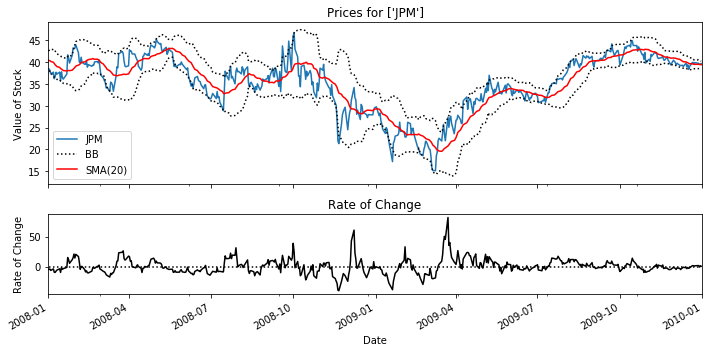

In [7]:
# 3. Momentum vs ROC (Choose which one you want, do not keep both!)
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=figsize_tup, sharex=True,
                      gridspec_kw={'height_ratios': [1, 0.5]})

ax[0].plot(prices, label = "JPM")
sma = SMA(prices, window=20)
bands = Bollinger_Bands(prices)
ax[0].plot(bands[0], color = "black", linestyle=":", label = "BB")
ax[0].plot(bands[1], color = "black", linestyle=":", label="_nolegend_")
ax[0].plot(sma, color = "red", label="SMA(20)")
ax[0].legend()

roc = rate_of_change(prices)*100
roc.plot(ax=ax[1],color="black",legend=False)

ax[0].set_title(f"Prices for {symbols}")
ax[0].set_xlabel("Date")
ax[1].set_xlabel("Date")
ax[0].set_ylabel("Value of Stock")
ax[1].set_ylabel("Rate of Change")
ax[1].set_title("Rate of Change")
ax[0].set_xlim(xlim_dates)
ax[1].set_xlim(xlim_dates)
ax[1].hlines(y=0,xmin=prices.index.min(),xmax=prices.index.max(), linestyle=":")
fig.tight_layout()
plt.show()

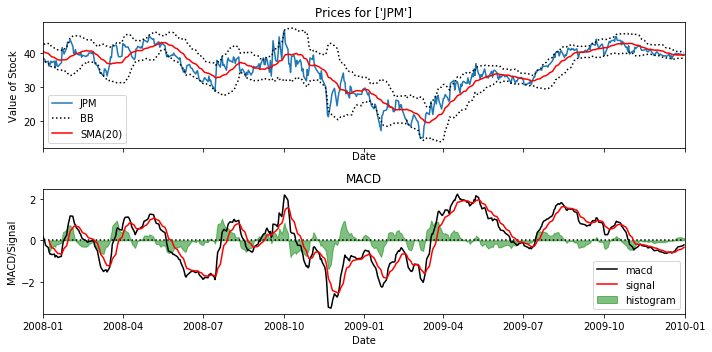

In [43]:
# 4. Moving Average Convergence Divergence (MACD)
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=figsize_tup, sharex=True,
                      gridspec_kw={'height_ratios': [1, 1]})

ax[0].plot(prices, label = "JPM")
sma = SMA(prices, window=20)
bands = Bollinger_Bands(prices)
ax[0].plot(bands[0], color = "black", linestyle=":", label = "BB")
ax[0].plot(bands[1], color = "black", linestyle=":", label="_nolegend_")
ax[0].plot(sma, color = "red", label="SMA(20)")
ax[0].legend()

macd, signal, histogram = MACD(prices)
ax[1].plot(macd,color="black",label="macd")
ax[1].plot(signal,color="red",label="signal")
# histogram.plot(kind="bar",ax=ax[2],color="green", alpha=0.5,legend=False)
ax[1].fill_between(x=histogram.index,y1=[0]*len(histogram),y2=[x[0] for x in histogram.values], color="green", alpha=0.5, label="histogram")
ax[1].legend()

ax[0].set_title(f"Prices for {symbols}")
ax[0].set_xlabel("Date")
ax[1].set_xlabel("Date")
ax[0].set_ylabel("Value of Stock")
ax[1].set_ylabel("MACD/Signal")
ax[1].set_title("MACD")
ax[1].hlines(y=0,xmin=prices.index.min(),xmax=prices.index.max(),linestyle=":")
ax[0].set_xlim(xlim_dates)
ax[1].set_xlim(xlim_dates)
fig.tight_layout()
plt.show()

In [51]:
histogram[histogram>0].loc["2009-03-01":"2009-04-01"].dropna()

,JPM
2009-03-02,0.017737
2009-03-03,0.006713
2009-03-12,0.267873
2009-03-13,0.506056
2009-03-16,0.601372
2009-03-17,0.765424
2009-03-18,0.956471
2009-03-19,0.903353
2009-03-20,0.718984
2009-03-23,0.914756


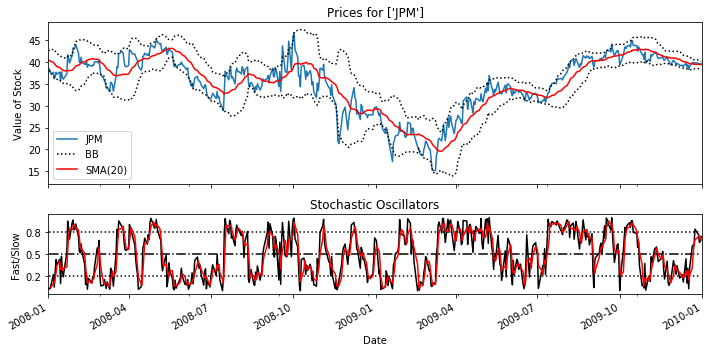

In [9]:
# 5. Stochastic Oscillators
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=figsize_tup, sharex=True,
                      gridspec_kw={'height_ratios': [1, 0.5]})

ax[0].plot(prices, label = "JPM")
sma = SMA(prices, window=20)
bands = Bollinger_Bands(prices)
ax[0].plot(bands[0], color = "black", linestyle=":", label = "BB")
ax[0].plot(bands[1], color = "black", linestyle=":", label="_nolegend_")
ax[0].plot(sma, color = "red", label="SMA(20)")
ax[0].legend()

fast, slow = Stochastic_Oscillators(prices)
fast.plot(ax=ax[1],color="black",legend=False)
slow.plot(ax=ax[1],color="red",legend=False)
#histogram.plot(kind="bar",ax=ax[1],color="green", alpha=0.5,legend=False)

ax[0].set_title(f"Prices for {symbols}")
ax[0].set_xlabel("Date")
ax[1].set_xlabel("Date")
ax[0].set_ylabel("Value of Stock")
ax[1].set_ylabel("Fast/Slow")
ax[1].set_title("Stochastic Oscillators")
ax[1].hlines(y=0.8,xmin=prices.index.min(),xmax=prices.index.max(),linestyle=":")
ax[1].hlines(y=0.5,xmin=prices.index.min(),xmax=prices.index.max(),linestyle="-.")
ax[1].hlines(y=0.2,xmin=prices.index.min(),xmax=prices.index.max(),linestyle=":")
ax[1].set_yticks([0.2,0.5,0.8])
ax[0].set_xlim(xlim_dates)
ax[1].set_xlim(xlim_dates)
fig.tight_layout()
plt.show()

In [10]:
prices.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>JPM</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>2008-01-02</th>\n      <td>38.47</td>\n    </tr>\n    <tr>\n      <th>2008-01-03</th>\n      <td>38.20</td>\n    </tr>\n    <tr>\n      <th>2008-01-04</th>\n      <td>37.33</td>\n    </tr>\n    <tr>\n      <th>2008-01-07</th>\n      <td>37.71</td>\n    </tr>\n    <tr>\n      <th>2008-01-08</th>\n      <td>36.21</td>\n    </tr>\n    <tr>\n      <th>2008-01-09</th>\n      <td>36.72</td>\n    </tr>\n    <tr>\n      <th>2008-01-10</th>\n      <td>37.70</td>\n    </tr>\n    <tr>\n      <th>2008-01-11</th>\n      <td>37.27</td>\n    </tr>\n    <tr>\n      <th>2008-01-14</th>\n      <td>37.73</td>\n    </tr>\n    <tr>\n      <th>2008-01-15</th>\n      <td>35.73</td>\n    </tr>\n    <tr>\n      <th>2008-01-16</th>\n      <td>37.79</td>\n    </tr>\n    <tr>\n      <th>2008-01-17</th>\n      <td>36.52</td>\n    </tr>\n  